# Milestone Poject 2 : skimLit

The purpose of this notebook is to build an NLP model to make reading medical abstracts easier.

The paper we're replicating (the source of the dataset that we'll be using) is available here : https://arxiv.org/abs/1710.06071
        
And reading through the paper above, we see that the model architecture that they use to achieve their best results is available : https://arxiv.org/abs/1612.05251
        
*Resource :* If you want to find the ground truth for this notebook(with lots of diagrams and text annotation) see the Github: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/09_SkimLit_nlp_milestone_project_2.ipynb



## Import dependencies

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# Import dependencies
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
# sys.path.append(r"C:\Users/wjub/01workspace/TensorFlow Developer Certificate ZTM")
sys.path.append(r"/content/drive/MyDrive/TensorFlow_Developer_Certificate_ZTM/")

import helper_functions
from helper_functions import calculate_results
import random

In [4]:
# Confirm acces to GPU
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



## Get data and process data

Since we'll be replicating the paper above (PubMed 200K RCT)? let's download the dataset they used,
We can do so from the authors GitHub : 

In [5]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
# Check what files are in the PubMed_20K dataset


fatal: destination path 'pubmed-rct' already exists and is not an empty directory.


In [6]:
ls pubmed-rct

PubMed_200k_RCT/
PubMed_200k_RCT_numbers_replaced_with_at_sign/
PubMed_20k_RCT/
PubMed_20k_RCT_numbers_replaced_with_at_sign/
README.md


In [7]:
ls pubmed-rct/PubMed_20k_RCT

dev.txt  test.txt  train.txt


In [8]:
# Start our experiments using the 20k dataset with numbers replaced by "#" sign
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [9]:
# Check all of the filenames in the target directory
import os
filenames= [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

### Preprocess data 

Now we've got some text data, it's time to become one with it.

And one of the best ways to become one with data is to...

> Visualize, visualize, vizualize

So with that in mind, let's write a function to read in all of the lines of a target text file.

In [10]:
# Create function to read lines of a document
def get_lines(filename):
    """
    Reads filename (a text filename) and returns the line of text as list.
    
    Args:
    	filename: a string containing the target filepath.
    Returns:
    	A list of strings with one string with one string per line from the target filename.  
    """
    with open(filename, "r") as f:
        return f.readlines()

In [11]:
# Let's read in the training lines
train_lines = get_lines(data_dir+"train.txt")
train_lines[:30]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [12]:
len(train_lines)

210040

In [13]:
from helper_functions import preprocess_text_with_line_numbers

In [14]:
# Get data from file and preprocess it 
%time
train_samples = preprocess_text_with_line_numbers(data_dir+"train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir+"dev.txt") # dev is another name for validation dataset
test_samples = preprocess_text_with_line_numbers(data_dir+"test.txt")
print(len(train_samples), len(val_samples), len(test_samples))

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 5.72 µs
180040 30212 30135


Now that our data is the frormat of a list of ditionaries, how about we turn it into dataframe to futher visualize it?

In [15]:
# check the first abstract_line
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(train_samples)
test_df = pd.DataFrame(train_samples)
#train_df["target"] = numeric_labels
train_df

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
...,...,...,...,...
180035,RESULTS,for the absolute change in percent atheroma vo...,7,11
180036,RESULTS,"for pav , a significantly greater percentage o...",8,11
180037,RESULTS,both strategies had acceptable side effect pro...,9,11
180038,CONCLUSIONS,"compared with standard statin monotherapy , th...",10,11


In [16]:
# Distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

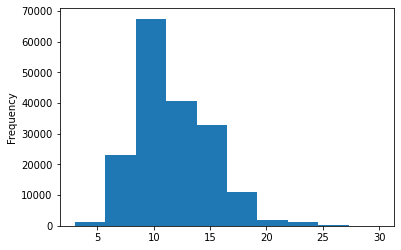

In [17]:
# let's check length of different lines
train_df.total_lines.plot.hist()

### Get lists of senteces

In [18]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)


(180040, 180040, 180040)

In [19]:
# View the 10 lines o ftraining sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

### Make numeric labels (ML models require numeric labels)

In [20]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False) # we want non-sparse matrix
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.fit_transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.fit_transform(test_df["target"].to_numpy().reshape(-1,1))

# check what one hot encoded labels look like
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [21]:
import tensorflow as tf
tf.constant(train_labels_one_hot)

<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])>

###  Label encode labels

In [22]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"])
val_labels_encoded = label_encoder.fit_transform(val_df["target"])
test_labels_encoded = label_encoder.fit_transform(test_df["target"])

# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [23]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

# Starting a series of modelling experiments...

As usual, we're going to be trying out a bunch of different models ans seeing which one works best.

And as always, we're going to start with a baseline (TF-IDF Multinomial Naive Bayes classifier).

## Model_0 : Getting a baseline

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline ([
    ("tfidf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])
# fit the pipeline to the training data
model_0.fit(train_sentences, train_labels_encoded)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [25]:
# Evaluate the model
baseline_score = model_0.score(val_sentences,val_labels_encoded)
print(f"our baseline model achive an accuracy of : {baseline_score}")

our baseline model achive an accuracy of : 0.7516829593423684


In [26]:
# make prediction
baseline_pred_probs = model_0.predict(val_sentences)
baseline_preds = tf.squeeze(tf.round(baseline_pred_probs))
baseline_preds[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([1, 2, 4, 2, 2, 4, 4, 4, 4, 4])>

In [27]:
model_0_results = helper_functions.calculate_results(val_labels_encoded, baseline_preds)
model_0_results

{'accuracy': 75.16829593423684,
 'precision': 0.7556121877731266,
 'recall': 0.7516829593423684,
 'f1': 0.734085177322999}

## Prepare our data (the text) for deep sequence models

Before we start building deeper models, we've got to create vectorization and embedding layers

In [28]:
# how long is each sentence on average ? 
sent_lens = [len(sentence.split()) for sentence in train_sentences] # list of length of words
avg_sent_len = np.mean(sent_lens)
avg_sent_len
#avg_sent_len, nb_word_per_sentence/len(train_sentences)

26.338269273494777

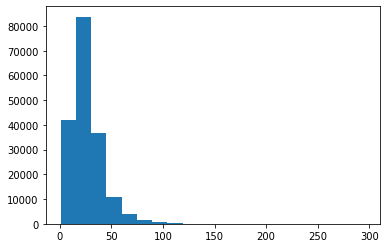

In [29]:
plt.hist(sent_lens, bins=20);

In [30]:
# How long  of sentence lenght covers 95% of examples
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len 

55

In [31]:
# Maximum sequence length in the training set
max(sent_lens)

296

## Embedding and tokenization
We want to make a layer which maps our texts from words to numbers

In [32]:
# How many words are in our vocab? (taken from table 2 in : https://arxiv.org/pdf/1710.06071.pdf)
max_tokens = 68000

In [33]:
# lets create a text vectorizer use text vectorisation layers of the last video
from helper_functions import tokenization, embedding
# init the tokenizer function
init_tokenizer = tokenization(train_sentences, output_seq_len, max_vocab_length=68000) 

# Choose a random sentence from the training dataset and tokenize it 
random_sentence = random.choice(train_sentences)
text_vectorizer = init_tokenizer([random_sentence])


In [34]:
# How many words in our training vocabulary
rct_20k_text_vocab = init_tokenizer.get_vocabulary()
print(f"Number of words i vocab:{len(rct_20k_text_vocab)}\n")
print(f"Most common words in the vocab:{rct_20k_text_vocab[:5]}\n")
print(f"least common words in the vocab:{rct_20k_text_vocab[-5:]}\n")

Number of words i vocab:64841

Most common words in the vocab:['', '[UNK]', 'the', 'and', 'of']

least common words in the vocab:['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']



In [35]:
init_tokenizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8'}

### Create custom text embedding

In [36]:
# Init embedding 
init_embedding = embedding( output_seq_len,len(rct_20k_text_vocab), output_seq_len)
text_embedding = init_embedding(text_vectorizer)
text_embedding

<tf.Tensor: shape=(1, 55, 128), dtype=float32, numpy=
array([[[-0.00640732,  0.04034306, -0.02953975, ...,  0.04115676,
         -0.00144864, -0.01034594],
        [-0.02696419, -0.01318447,  0.02535577, ...,  0.02659195,
          0.04818929,  0.00216205],
        [-0.02783396, -0.04628792,  0.0109282 , ..., -0.04912652,
          0.00235487,  0.02229785],
        ...,
        [-0.0365976 , -0.01149233,  0.0148246 , ..., -0.02867839,
         -0.01526328,  0.02219756],
        [-0.0365976 , -0.01149233,  0.0148246 , ..., -0.02867839,
         -0.01526328,  0.02219756],
        [-0.0365976 , -0.01149233,  0.0148246 , ..., -0.02867839,
         -0.01526328,  0.02219756]]], dtype=float32)>

In [37]:
# Show example embedding
print(f"Sentence before vectorization:\n {random_sentence}\n")
print(f"sentence after vectorization: \n {text_vectorizer}")
print(f"sentence after embedding: \n {text_embedding}")
print(f"embedding sentence shape:\n {text_embedding.shape}")

Sentence before vectorization:
 these were generally mild to moderate in intensity , none were serious , and few led to discontinuation .

sentence after vectorization: 
 [[ 111    9 1153  533    6  362    5  579 1113    9  528    3  899 1173
     6 1565    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]
sentence after embedding: 
 [[[-0.00640732  0.04034306 -0.02953975 ...  0.04115676 -0.00144864
   -0.01034594]
  [-0.02696419 -0.01318447  0.02535577 ...  0.02659195  0.04818929
    0.00216205]
  [-0.02783396 -0.04628792  0.0109282  ... -0.04912652  0.00235487
    0.02229785]
  ...
  [-0.0365976  -0.01149233  0.0148246  ... -0.02867839 -0.01526328
    0.02219756]
  [-0.0365976  -0.01149233  0.0148246  ... -0.02867839 -0.01526328
    0.02219756]
  [-0.0365976  -0.01149233  0.0148246  ... -0.02867839 -0.01526328
    0.02219756]]]
embedding 

## Creating datasets (making sure our data loads as fast as possible)

We're going to setup our data to run as fast a possible with the TensorFlow tf.data API, many of the steps here are discussed at length in these two resources:
* https://www.tensorflow.org/guide/data_performance
* https://www.tensorflow.org/guide/data

In [38]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [39]:
train_labels_one_hot.shape, train_labels_one_hot[0]

((180040, 5), array([0., 0., 0., 1., 0.]))

In [40]:
# Take the TensorSliceDataset's and turn them into prefechted data
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [41]:
len(train_dataset)

5627

## Model 1 : Conv1D with token embeddings

In [42]:
# Create 1D conv model to process sequences
num_classes

5

In [43]:
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D, Dense, Input
# create victorization, create embedding layer, create conv1D, pooling, dense layer
model_1 = tf.keras.Sequential([
    Input(shape=(1), dtype=tf.string, name='input_layer'),
    init_tokenizer,
    init_embedding,
    Conv1D(64, kernel_size=5, padding='same', activation='relu'),
    GlobalAveragePooling1D(), # Condense the output of our feature vector from conv layer
    Dense(num_classes, activation='softmax')
], name='Conv1D')

# compile the model
model_1.compile(loss= "categorical_crossentropy",
               optimizer = tf.keras.optimizers.Adam(),
               metrics = ['accuracy'])
model_1.summary()

Model: "Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325       
                                                                 
Total params: 8,340,997
Trainable params: 8,340,997
Non-trai

In [44]:
# fit the model
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)), 
                              epochs=3,
                              validation_data= valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset)),
                              callbacks=[helper_functions.create_tensorboard_callback(dir_name="tensorboard",
                                                                                    experiment_name="model_1_conv1D")])

Saving TensorBoard log files to: tensorboard/model_1_conv1D/20230216-132726
Epoch 1/3
562/562 [==============================] - 47s 82ms/step - loss: 0.9205 - accuracy: 0.6350 - val_loss: 0.5646 - val_accuracy: 0.7928
Epoch 2/3
562/562 [==============================] - 48s 86ms/step - loss: 0.6583 - accuracy: 0.7550 - val_loss: 0.5420 - val_accuracy: 0.8128
Epoch 3/3
562/562 [==============================] - 47s 83ms/step - loss: 0.6185 - accuracy: 0.7746 - val_loss: 0.5279 - val_accuracy: 0.8171


In [45]:
# Evaluate on whole validation dataset
model_1.evaluate(valid_dataset)

5627/5627 [==============================] - 30s 5ms/step - loss: 0.5717 - accuracy: 0.7980


[0.5717207193374634, 0.7979837656021118]

In [46]:
# Make predictions (our model predicts prediction probabilies for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape # output = proba of ['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS']

5627/5627 [==============================] - 30s 5ms/step


(array([[9.2020825e-02, 2.0638216e-02, 2.0198147e-05, 8.8732040e-01,
         4.0639242e-07],
        [1.9528758e-04, 6.0458452e-04, 9.3729687e-01, 1.4201649e-04,
         6.1761208e-02],
        [2.0773731e-02, 7.9639718e-02, 4.9316570e-01, 1.1644370e-02,
         3.9477643e-01],
        ...,
        [2.4970742e-02, 2.7837327e-01, 5.2941903e-02, 1.4577460e-02,
         6.2913656e-01],
        [5.0579119e-02, 7.2664958e-01, 9.8904613e-03, 5.3778663e-02,
         1.5910223e-01],
        [4.4136456e-01, 6.3949108e-02, 1.4548062e-01, 3.3744535e-01,
         1.1760291e-02]], dtype=float32), (180040, 5))

In [47]:
# Convert pred_probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(180040,), dtype=int64, numpy=array([3, 2, 2, ..., 4, 1, 0])>

In [48]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                   y_pred=model_1_preds)
model_1_results

{'accuracy': 79.79837813819152,
 'precision': 0.7956378165752153,
 'recall': 0.7979837813819152,
 'f1': 0.7956761753809309}

## Model_2 : TensorFlow Hub Pretrained Feature Extractor

Now lets use pretrained word embedding from TensorFlow Hub, more specifically the universal sentence encoder(universal-sentence-encoder): https://tfhub.dev/google/universal-sentence-encoder/4

The paper originally used GloVee embeddings, however, we're going to stick with the later created USE pretrained embedding

In [49]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub

tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                  trainable=False,
                                  name="universal_sentence_encoder")
embeddings = tf_hub_embedding_layer([
    "The quick brown fox jumps over the lazy dog.",
    "I am a sentence for which I would like to get its embedding"])

print(embeddings)

tf.Tensor(
[[-0.03133017 -0.06338634 -0.01607501 ... -0.03242778 -0.0457574
   0.05370456]
 [ 0.0508086  -0.01652434  0.01573779 ...  0.00976657  0.03170121
   0.01788118]], shape=(2, 512), dtype=float32)


In [50]:
# Test out the pretrained embedding on a random sentence
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence:\n {random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"sentence after embedding:\n{use_embedded_sentence[0][:30]}")
print(f"Length of sentence embedding: {len(use_embedded_sentence[0])}")

Random sentence:
 plh ( n = @ ) , primarily african american and latino , were recruited from @ aids services organizations and randomly assigned to daily smartphone ( n = @ ) or biweekly web-survey only ( n = @ ) self-monitoring for @ weeks .
sentence after embedding:
[-0.0202602  -0.05548302 -0.04607042 -0.03089369 -0.02325394  0.01474297
  0.06940919 -0.03727877 -0.04959169 -0.04887467  0.01586355  0.05281921
 -0.01149608 -0.00423843  0.03505873 -0.03587085 -0.04713528  0.03898248
 -0.04793912 -0.02955294  0.0750944  -0.02788583 -0.01657537 -0.02129898
  0.01456658  0.06602766 -0.03434595 -0.02275506 -0.04156079 -0.01757731]
Length of sentence embedding: 512


### Building and fitting an NLP feature extraction model using pretrained embeddings from TensorFlow Hub 

In [51]:
model_2 = tf.keras.Sequential([
    tf_hub_embedding_layer,
    tf.keras.layers.Dense(5, activation='sigmoid')
])
# compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [52]:
# fit the model
model_2.fit(train_dataset,
            steps_per_epoch=int(0.1*len(train_dataset)),
            epochs=3,
            validation_data=valid_dataset,
            validation_steps=int(0.1*len(valid_dataset)),
            callbacks=[helper_functions.create_tensorboard_callback(dir_name="tensorboard",
                                                                    experiment_name="model_2_tf_hub_embed")])

Saving TensorBoard log files to: tensorboard/model_2_tf_hub_embed/20230216-133100
Epoch 1/3


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


562/562 [==============================] - 14s 19ms/step - loss: 1.2577 - accuracy: 0.5429 - val_loss: 1.0868 - val_accuracy: 0.6024
Epoch 2/3
562/562 [==============================] - 11s 19ms/step - loss: 1.0115 - accuracy: 0.6264 - val_loss: 0.9595 - val_accuracy: 0.6510
Epoch 3/3
562/562 [==============================] - 11s 19ms/step - loss: 0.9312 - accuracy: 0.6548 - val_loss: 0.9002 - val_accuracy: 0.6720


In [53]:
model_2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=[], dtype="string"),
    tf_hub_embedding_layer, # tokenize text and create embedding of each sequence (512 long vector)
    tf.keras.layers.Dense(128, activation="relu"),
    # Note : you could add more layers here if you wanted to
    tf.keras.layers.Dense(num_classes, activation='sigmoid', name="output_layer")
], name="model_2_tf_hub_embed")

# compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [54]:
# fit the model
history_model_2 = model_2.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset)),
                              callbacks=[helper_functions.create_tensorboard_callback(dir_name="tensorboard",
                                                                    experiment_name="model_2_tf_hub_embed")])

Saving TensorBoard log files to: tensorboard/model_2_tf_hub_embed/20230216-133136
Epoch 1/3
562/562 [==============================] - 13s 22ms/step - loss: 0.9195 - accuracy: 0.6488 - val_loss: 0.7794 - val_accuracy: 0.7055
Epoch 2/3
562/562 [==============================] - 12s 21ms/step - loss: 0.7677 - accuracy: 0.7040 - val_loss: 0.7502 - val_accuracy: 0.7140
Epoch 3/3
562/562 [==============================] - 12s 21ms/step - loss: 0.7494 - accuracy: 0.7142 - val_loss: 0.7377 - val_accuracy: 0.7156


In [55]:
# Evaluate on the whole validation dataset
model_2.evaluate(valid_dataset)

5627/5627 [==============================] - 56s 10ms/step - loss: 0.7401 - accuracy: 0.7142


[0.7400971055030823, 0.7142357230186462]

In [56]:

# Make some prediction wit feature extraction model
model_2_pred_probs = model_2.predict(val_sentences)

5627/5627 [==============================] - 63s 11ms/step


In [57]:
# convert the prediction probabilities found with feature extraction model to label
model_2_pred = tf.argmax(model_2_pred_probs, axis=1) # les positions des  valeur les plus grandes 
model_2_pred

<tf.Tensor: shape=(180040,), dtype=int64, numpy=array([3, 2, 2, ..., 1, 1, 2])>

In [58]:
# Calcute results performance from TF Hub pretrained embeddings results on val set
model_2_results = calculate_results(y_true =val_labels_encoded,
                                    y_pred = model_2_pred)
model_2_results

{'accuracy': 71.42357253943568,
 'precision': 0.7165272032393702,
 'recall': 0.7142357253943568,
 'f1': 0.7114869261939253}

In [59]:
model_0_results

{'accuracy': 75.16829593423684,
 'precision': 0.7556121877731266,
 'recall': 0.7516829593423684,
 'f1': 0.734085177322999}

In [60]:
model_1_results

{'accuracy': 79.79837813819152,
 'precision': 0.7956378165752153,
 'recall': 0.7979837813819152,
 'f1': 0.7956761753809309}

## Model 3: Conv1D with character embeddngs

The paper which we're replicating states they used a combination of token and character-level embeddings.
:
Previously we've token-level embeddings but we'll need to do similar steps for characters if we want to use char-level embeddings.

### Create a characterlevel tokenizer

In [61]:
# tr = train_sentences.split("")
#init_tokenizer
type(train_sentences)

list

In [62]:
def split_chars(text):
  return " ".join(list(text))

# Text splitting non-character-level sequence into characters
split_chars(random_train_sentence)

'p l h   (   n   =   @   )   ,   p r i m a r i l y   a f r i c a n   a m e r i c a n   a n d   l a t i n o   ,   w e r e   r e c r u i t e d   f r o m   @   a i d s   s e r v i c e s   o r g a n i z a t i o n s   a n d   r a n d o m l y   a s s i g n e d   t o   d a i l y   s m a r t p h o n e   (   n   =   @   )   o r   b i w e e k l y   w e b - s u r v e y   o n l y   (   n   =   @   )   s e l f - m o n i t o r i n g   f o r   @   w e e k s   .'

In [63]:
# Split sequence-level data splits into character-level data splits 
train_chars = [split_chars(sentence) for sentence in train_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
train_chars[0]

't o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .'

In [64]:
# What's the average character length ?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

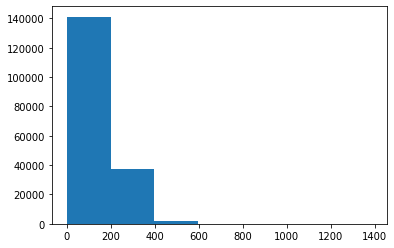

In [65]:
# Check the distribution of our sequences at a character-level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7);

In [66]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [67]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [68]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV token (OOV = out of vocab, '[UNK]')


    # Create a text vectorizer 
char_vectorizer = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens = NUM_CHAR_TOKENS,
                                                                               output_sequence_length= output_seq_char_len,
                                                                               #standardize=None, # set standardization to "None" if you want leave the ponctuation in
                                                                               name="char_vectorizer")


In [69]:
# Adapt character vectorizer to training character
char_vectorizer.adapt(train_chars)

In [70]:
 # Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [71]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n {random_train_chars}")
print(f"Length of random_train_chars: {len(random_train_chars)}")

vectorized_chars = char_vectorizer([random_train_chars])
print(f"\Vectorized chars:\n {vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
 i n s o m n i a   i s   p r e v a l e n t   a m o n g   p a t i e n t s   w i t h   k n e e   o s t e o a r t h r i t i s   (   o a   )   .
Length of random_train_chars: 139
\Vectorized chars:
 [[ 4  6  9  7 15  6  4  5  4  9 14  8  2 21  5 12  2  6  3  5 15  7  6 18
  14  5  3  4  2  6  3  9 20  4  3 13 23  6  2  2  7  9  3  2  7  5  8  3
  13  8  4  3  4  9  7  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

### Creating a character level embedding

In [72]:
# Create char embedding layer
char_embed = tf.keras.layers.Embedding(input_dim=len(char_vocab), # this is the number of differente characters
                                       output_dim= 25, # is the size of char_embedding in  the paper (figure 1)
                                       mask_zero=True,
                                       name="char_embed")

In [73]:
# Test our character embedding layer
print(f"Charified text:\n {random_train_chars}")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f" Embedded chars. (after vectorization and embedding) :\n {char_embed_example}")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text:
 i n s o m n i a   i s   p r e v a l e n t   a m o n g   p a t i e n t s   w i t h   k n e e   o s t e o a r t h r i t i s   (   o a   )   .
 Embedded chars. (after vectorization and embedding) :
 [[[ 0.01129224 -0.02377061  0.01864542 ...  0.03910102 -0.01449888
    0.02799447]
  [ 0.04355777  0.00936852  0.03799505 ... -0.02636167 -0.0048767
   -0.00979437]
  [ 0.00613578  0.01996262  0.0455527  ... -0.02652162 -0.03771144
   -0.0031383 ]
  ...
  [-0.02345011 -0.03559188 -0.03917541 ... -0.02600325  0.00341233
   -0.00868342]
  [-0.02345011 -0.03559188 -0.03917541 ... -0.02600325  0.00341233
   -0.00868342]
  [-0.02345011 -0.03559188 -0.03917541 ... -0.02600325  0.00341233
   -0.00868342]]]
Character embedding shape: (1, 290, 25)


In [74]:
len(random_train_chars)

139

In [75]:
# Check the image in notion and build a model like this

### Building a Conv1D model to fit on character embeddings

In [76]:
# Create the model
model_3 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1,), dtype=tf.string, name="input_layer"),
    char_vectorizer,
    char_embed,
    tf.keras.layers.Conv1D(64,kernel_size=5, padding="same", activation="relu"),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dense(num_classes,activation="softmax",name="output_layer")
], name="Conv1D_char_embed")

# Compile the model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


In [77]:
model_3.summary()

Model: "Conv1D_char_embed"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 output_layer (Dense)        (None, 5)                 325       
                                                                 
Total params: 9,089
Trainable params: 9,089
Non-t

In [78]:
# Create char level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [79]:
# Fit the model
history_model_3 = model_3.fit(train_char_dataset,
                             steps_per_epoch=int(0.1*len(train_char_dataset)),
                             epochs=3,
                             validation_data=val_char_dataset,
                             validation_steps=int(0.1*len(val_char_dataset)),
                             callbacks=[helper_functions.create_tensorboard_callback(dir_name="tensorboard",
                                                                                     experiment_name="model_3_conv1D_embed_char")])

Saving TensorBoard log files to: tensorboard/model_3_conv1D_embed_char/20230216-133451
Epoch 1/3
562/562 [==============================] - 17s 30ms/step - loss: 1.2533 - accuracy: 0.5026 - val_loss: 1.0353 - val_accuracy: 0.6003
Epoch 2/3
562/562 [==============================] - 21s 38ms/step - loss: 1.0025 - accuracy: 0.5978 - val_loss: 0.9589 - val_accuracy: 0.6243
Epoch 3/3
562/562 [==============================] - 16s 29ms/step - loss: 0.9213 - accuracy: 0.6424 - val_loss: 0.8845 - val_accuracy: 0.6598


In [80]:
# Make prediction with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)

5627/5627 [==============================] - 37s 7ms/step


In [81]:
# Convert preddiction probabilies to class labels
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(180040,), dtype=int64, numpy=array([1, 2, 1, ..., 1, 4, 3])>

In [82]:
model_3_results = calculate_results(y_true=train_labels_encoded, y_pred=model_3_preds)
model_3_results

{'accuracy': 65.54043545878694,
 'precision': 0.6483076614285449,
 'recall': 0.6554043545878694,
 'f1': 0.6465787631169752}

## Model 4: Combining pretrained token embedding + characters embedding (hybrid embedding)

1. Create a token-level embedding model (similar `model_1`).
2. Create a character-level model (similar to `model_3` with a slight modification)
3. Combine 1 & 3 with a concatenate (`layers.Concatenate`).
4. Build a series of output layers on top of 3 similar to Figure 1 and section 4.2(Training) of the paper https://arxiv.org/pdf/1612.05251.pdf.
5. Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output.

In [83]:
# 1. Setup token inputs/model
token_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=[], dtype=tf.string, name="token_input"),
    tf_hub_embedding_layer,
    tf.keras.layers.Dense(128, activation="relu", name="output_layer")
], name="token_model")

# 2. Setup char inputs/model
char_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1,), dtype=tf.string, name="char_input"),
    char_vectorizer,
    char_embed,
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24), name="bi_lstm_output_layer")
], name="char_model")

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = tf.keras.layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                    char_model.output])
# 4. Create output layers - adding in Dropout, discussed in section 4.2
combined_dropout = tf.keras.layers.Dropout(0.5)(token_char_concat)
combined_dense = tf.keras.layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = tf.keras.layers.Dropout(0.5)(combined_dense)
output_layer = tf.keras.layers.Dense(num_classes, activation="sigmoid")(final_dropout)

# output_layer = tf.keras.Sequential([
#     tf.keras.layers.Dropout(0.5)(token_char_concat), # combined_dropout
#     tf.keras.layers.Dense(128, activation="relu"),   # combined_dense
#     tf.keras.layers.Dropout(0.5),                   # final_dropout
#     tf.keras.layers.Dense(num_classes, activation="sigmoid")
# ])

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

In [84]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

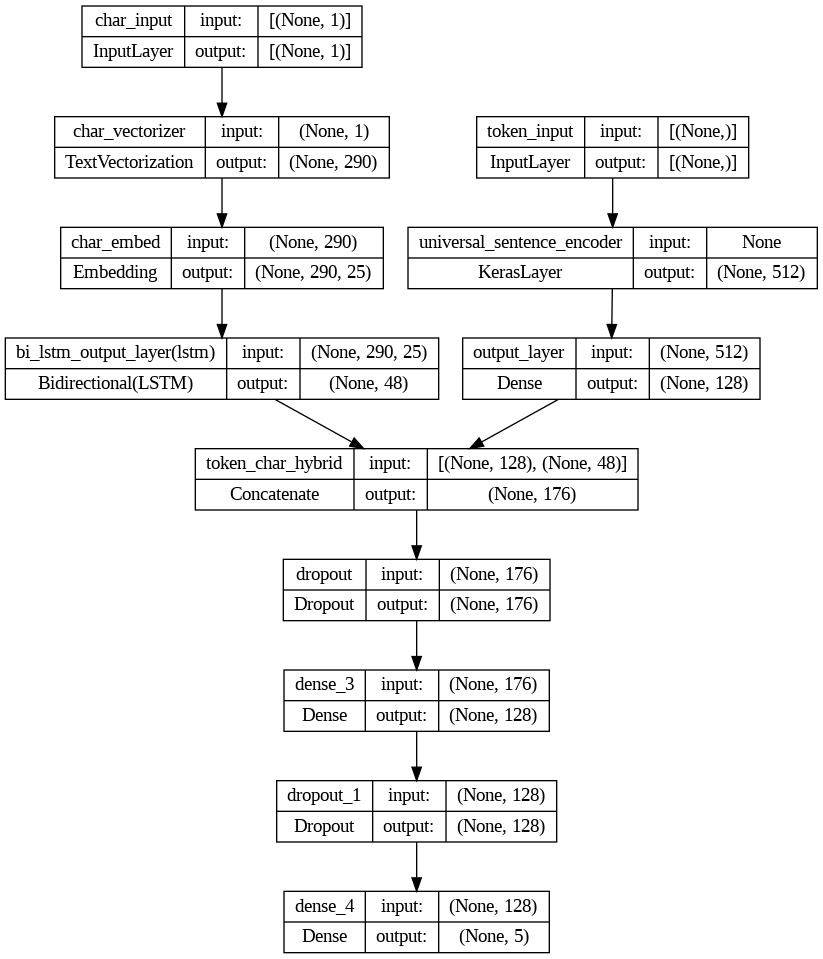

In [85]:
# Plot hybrid token and charcter model
from keras.utils import plot_model
plot_model(model_4, show_shapes=True)

In [86]:
 # Compile token char model
 model_4.compile(loss="categorical_crossentropy",
                 optimizer=tf.keras.optimizers.Adam(), # section 4.2 of the paper says use SGD
                 metrics=["accuracy"])

### Combining and characer data into a tf.data Dataset

In [87]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data with labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [88]:
# Repeat the above steps for our validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars)) # make data
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot) # make labels
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels)) # combine data with labels

# Prefetch and batch train data
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [89]:
train_char_token_dataset

<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [90]:
 val_char_token_dataset

<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

### Fitting a model on token and character-level sequences

In [91]:
# Fit the model on tokens and chars
history_model_4 = model_4.fit(train_char_token_dataset,
                              steps_per_epoch=int(0.1*len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1*len(val_char_token_dataset)),
                              callbacks=[helper_functions.create_tensorboard_callback(dir_name="tensorboard",
                                                                                      experiment_name="model_4")])

Saving TensorBoard log files to: tensorboard/model_4/20230216-133633
Epoch 1/3
562/562 [==============================] - 198s 337ms/step - loss: 0.9860 - accuracy: 0.6099 - val_loss: 0.7671 - val_accuracy: 0.7083
Epoch 2/3
562/562 [==============================] - 174s 310ms/step - loss: 0.7918 - accuracy: 0.6930 - val_loss: 0.7127 - val_accuracy: 0.7344
Epoch 3/3
562/562 [==============================] - 177s 316ms/step - loss: 0.7755 - accuracy: 0.7055 - val_loss: 0.7063 - val_accuracy: 0.7354


In [92]:
# Evaluate one the whole validation dataset
model_4.evaluate(val_char_token_dataset)

5627/5627 [==============================] - 319s 57ms/step - loss: 0.7072 - accuracy: 0.7307


[0.7071909308433533, 0.7307043075561523]

In [93]:
# Make predictions using the token-character model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)
# Format pred probs into pred labels 
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds[:5]

5627/5627 [==============================] - 324s 57ms/step


<tf.Tensor: shape=(5,), dtype=int64, numpy=array([3, 2, 2, 2, 2])>

In [94]:
# get results of token-char-hybrid model
model_4_results = calculate_results(y_true=val_labels_encoded, y_pred=model_4_preds)
model_4_results

{'accuracy': 73.07042879360142,
 'precision': 0.7320319525680188,
 'recall': 0.7307042879360143,
 'f1': 0.7286528099444245}

In [95]:
# Get results of token-char-hybrid model


## Model 5 : Transfer learning with pretrained token embeddings + character embeddings + positional embeddings

In [96]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


> **Note:** Any engineered features used to train a model need to be available at test time. In our case, line numbers and total lines are available.